1.) Unzip Custom Enviroment and Graph Data

In [ ]:
!unzip Graphs_and_Env.zip
from IPython.display import clear_output
clear_output(wait=False)

2.) Install Necessary Packages

In [ ]:
!pip install stable-baselines3[extra]
!pip install imitation
!pip install dgl=2.2.1
!apt-get update && apt-get install swig cmake
!pip install box2d-py
!pip install "stable-baselines3[extra]>=2.0.0a4"

from IPython.display import clear_output
clear_output(wait=False)

In [ ]:
!python --version
!sudo apt-get install python3.10
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10.0 1
!python --version

Python 3.10.12
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10 is already the newest version (3.10.12-1~22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
update-alternatives: using /usr/bin/python3.10 to provide /usr/bin/python3 (python3) in auto mode
Python 3.10.12


3.) Import Necessary Packages

In [ ]:
from numpy import e, linalg as LA
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import matplotlib.colors as colors
import matplotlib.cm as cmx
#import dgl
import networkx as nx
from matplotlib.cm import ScalarMappable

import gymnasium as gym
from gymnasium import error, spaces, utils
from gymnasium.utils import seeding

from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import VecMonitor
from stable_baselines3.common import results_plotter
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env

from imitation.algorithms import preference_comparisons
from imitation.policies.base import FeedForward32Policy, NormalizeFeaturesExtractor, RandomPolicy, ZeroPolicy, NonTrainablePolicy
from imitation.rewards.reward_nets import BasicRewardNet
from imitation.rewards.reward_wrapper import RewardVecEnvWrapper
from imitation.util.networks import RunningNorm

import ale_py
import shimmy
import os
import warnings
warnings.filterwarnings("ignore")

os.chdir('/content/Graphs_and_Env/gym-graph')

import gym_graph
os.chdir('/content/')

4.) Functions to read in graph data, compute objective value, and display training plots

In [ ]:
# function to get adjacency matrix, laplacian matrix, and edge count
def get_adj_lap(filename):
  file = open(filename, "r")
  A = file.readlines()
  length = len(A)

  A2 = np.zeros(length)
  count = 0
  for line in A:
      A2[count] = line.strip()
      count += 1

  nVertices = int(math.sqrt(length))
  A = np.zeros((nVertices,nVertices))
  L = np.zeros((nVertices,nVertices))
  counter = 0
  edge_count = 0

  for i in range(nVertices):
    for j in range(nVertices):
      L[i,j] = float(A2[counter])
      if(i != j):
        A[i,j] = -float(A2[counter])
      if(j > i):
        if(A[i,j] > 0):
          edge_count = edge_count + 1
      counter = counter + 1

  return A, L, edge_count

# function to calculate objection function value
def Obj_Val(L):
  nVertices = len(L[:,0])
  eigenvalues1, eigenvectors1 = LA.eig(L)
  L = L + 0.1*np.identity(nVertices)
  eigenvalues, eigenvectors = LA.eig(L)
  ev = np.sort(eigenvalues)
  print("Sum of Eigenvalues read from file:",np.sum(eigenvalues1))
  gamma = 0.001
  h = 0.1

  value = 0
  for i in range(len(ev)):
      lambda_i = ev[i]
      for j in range(len(ev)):
          lambda_j = ev[j]
          value += ((h*(h**2+lambda_j)+h*lambda_i) / (gamma*nVertices*lambda_j*(lambda_i**2+2*lambda_i*(h**2-lambda_j)+(h**2+lambda_j)**2)))

  value /= nVertices

  return abs(value), eigenvalues

# wrapper class for saving training results for plotting
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

# helping function for plotting
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")

# function to plot training results
def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)

    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

5.) Check if custom enviroment properly registered (Optional) - At the end should be 'gym_graph/GraphEnv'

In [ ]:
print(gym.envs.registration.registry.keys())

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV26Environment-v0', 'GymV21Environment-v0', 'Adventure-v0', 'AdventureDeterministic-v0', 'AdventureNoFrameskip-v0

6.) Preference Comparison Training

In [ ]:
# read in graph data and get Adjacency and Laplacian matrices and number of edges
A,L,num_edges = get_adj_lap("Graphs_and_Env/Initial-Laplacian.txt")

# used for wrapper function
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# define random number generator
rng = np.random.default_rng(0)

# create vectorized environment
venv = make_vec_env("gym_graph/GraphEnv",
    n_envs=1,
    env_kwargs={'nodes':A})

# wrapper function to save trainig results for plotting
venv = VecMonitor(venv, log_dir)

# MLP that takes as input the state, action, next state and done flag.
# inputs are flattened and then concatenated to one another
reward_net = BasicRewardNet(
    venv.observation_space, venv.action_space, normalize_input_layer=RunningNorm,
)

# Sample fragments of trajectories uniformly at random with replacement.
fragmenter = preference_comparisons.RandomFragmenter(warning_threshold=0, rng=rng)

# Computes synthetic preferences using ground-truth environment rewards.
gatherer = preference_comparisons.SyntheticGatherer(rng=rng)

# Class to convert two fragments’ rewards into preference probability.
preference_model = preference_comparisons.PreferenceModel(reward_net)

# Train a basic reward model.
reward_trainer = preference_comparisons.BasicRewardTrainer(
    preference_model=preference_model,
    loss=preference_comparisons.CrossEntropyRewardLoss(),
    epochs=5,
    rng=rng,
)

# define Proximal Policy Optimization algorithm
model = PPO(
    policy=FeedForward32Policy,
    policy_kwargs=dict(
        features_extractor_class=NormalizeFeaturesExtractor,
        features_extractor_kwargs=dict(normalize_class=RunningNorm),
    ),
    env=venv,
    n_steps=2048 // venv.num_envs,
    clip_range=0.1,
    ent_coef=0.1,
    gae_lambda=0.95,
    n_epochs=5,
    gamma=0.97,
    learning_rate=2e-3,
)

# Wrapper for training an SB3 algorithm on an arbitrary reward function
trajectory_generator = preference_comparisons.AgentTrainer(
    algorithm=model,
    reward_fn=reward_net,
    venv=venv,
    exploration_frac=0.05,
    rng=rng,
)

# Main interface for reward learning using preference comparisons.
pref_comparisons = preference_comparisons.PreferenceComparisons(
    trajectory_generator,
    reward_net,
    num_iterations=5,
    fragmenter=fragmenter,
    preference_gatherer=gatherer,
    reward_trainer=reward_trainer,
    initial_epoch_multiplier=2,
    initial_comparison_frac=0.01,
    query_schedule="hyperbolic",
)

pref_comparisons.fragment_length = 1

# Train PPO
pref_comparisons.train(total_timesteps=25_000, total_comparisons=200)

# Evaluate learned policy
n_eval_episodes = 1
reward_mean, reward_std = evaluate_policy(model.policy, venv, n_eval_episodes)
reward_stderr = reward_std/np.sqrt(n_eval_episodes)
print(f"Reward: {reward_mean:.0f} +/- {reward_stderr:.0f}")

Query schedule: [2, 56, 45, 37, 32, 28]
No exploration steps included: exploration_frac = 0.05 > 0 but steps=4 is too small.
Requested 4 transitions but only 0 in buffer. Sampling 4 additional transitions.
Creating fragment pairs
Gathering preferences
Dataset now contains 2 comparisons


Training reward model:   0%|          | 0/10 [00:00<?, ?it/s]

Training agent for 5000 timesteps
---------------------------------------------------
| raw/                                 |          |
|    agent/rollout/ep_len_mean         | 1        |
|    agent/rollout/ep_rew_mean         | 0.0122   |
|    agent/rollout/ep_rew_wrapped_mean | -0.0557  |
|    agent/time/fps                    | 131      |
|    agent/time/iterations             | 1        |
|    agent/time/time_elapsed           | 15       |
|    agent/time/total_timesteps        | 2048     |
---------------------------------------------------
----------------------------------------------------
| raw/                                 |           |
|    agent/rollout/ep_len_mean         | 1         |
|    agent/rollout/ep_rew_mean         | 0.0125    |
|    agent/rollout/ep_rew_wrapped_mean | -0.0825   |
|    agent/time/fps                    | 132       |
|    agent/time/iterations             | 2         |
|    agent/time/time_elapsed           | 30        |
|    agent/time/total_

Training reward model:   0%|          | 0/5 [00:00<?, ?it/s]

Training agent for 5000 timesteps
----------------------------------------------------
| raw/                                 |           |
|    agent/rollout/ep_len_mean         | 1         |
|    agent/rollout/ep_rew_mean         | 0.013     |
|    agent/rollout/ep_rew_wrapped_mean | 4.9       |
|    agent/time/fps                    | 145       |
|    agent/time/iterations             | 1         |
|    agent/time/time_elapsed           | 14        |
|    agent/time/total_timesteps        | 8192      |
|    agent/train/approx_kl             | 23.817982 |
|    agent/train/clip_fraction         | 0.97      |
|    agent/train/clip_range            | 0.1       |
|    agent/train/entropy_loss          | -923      |
|    agent/train/explained_variance    | 0         |
|    agent/train/learning_rate         | 0.002     |
|    agent/train/loss                  | -97.7     |
|    agent/train/n_updates             | 15        |
|    agent/train/policy_gradient_loss  | 0.269     |
|    agent/t

Training reward model:   0%|          | 0/5 [00:00<?, ?it/s]

Training agent for 5000 timesteps
----------------------------------------------------
| raw/                                 |           |
|    agent/rollout/ep_len_mean         | 1         |
|    agent/rollout/ep_rew_mean         | 0.0133    |
|    agent/rollout/ep_rew_wrapped_mean | -0.06     |
|    agent/time/fps                    | 145       |
|    agent/time/iterations             | 1         |
|    agent/time/time_elapsed           | 14        |
|    agent/time/total_timesteps        | 14336     |
|    agent/train/approx_kl             | 26.453243 |
|    agent/train/clip_fraction         | 0.972     |
|    agent/train/clip_range            | 0.1       |
|    agent/train/entropy_loss          | -1.31e+03 |
|    agent/train/explained_variance    | 0         |
|    agent/train/learning_rate         | 0.002     |
|    agent/train/loss                  | -138      |
|    agent/train/n_updates             | 30        |
|    agent/train/policy_gradient_loss  | 0.27      |
|    agent/t

Training reward model:   0%|          | 0/5 [00:00<?, ?it/s]

Training agent for 5000 timesteps
----------------------------------------------------
| raw/                                 |           |
|    agent/rollout/ep_len_mean         | 1         |
|    agent/rollout/ep_rew_mean         | 0.0134    |
|    agent/rollout/ep_rew_wrapped_mean | 0.0261    |
|    agent/time/fps                    | 146       |
|    agent/time/iterations             | 1         |
|    agent/time/time_elapsed           | 13        |
|    agent/time/total_timesteps        | 20480     |
|    agent/train/approx_kl             | 25.052006 |
|    agent/train/clip_fraction         | 0.965     |
|    agent/train/clip_range            | 0.1       |
|    agent/train/entropy_loss          | -1.7e+03  |
|    agent/train/explained_variance    | 0         |
|    agent/train/learning_rate         | 0.002     |
|    agent/train/loss                  | -177      |
|    agent/train/n_updates             | 45        |
|    agent/train/policy_gradient_loss  | 0.263     |
|    agent/t

Training reward model:   0%|          | 0/5 [00:00<?, ?it/s]

Training agent for 5000 timesteps
----------------------------------------------------
| raw/                                 |           |
|    agent/rollout/ep_len_mean         | 1         |
|    agent/rollout/ep_rew_mean         | 0.0135    |
|    agent/rollout/ep_rew_wrapped_mean | 0.103     |
|    agent/time/fps                    | 133       |
|    agent/time/iterations             | 1         |
|    agent/time/time_elapsed           | 15        |
|    agent/time/total_timesteps        | 26624     |
|    agent/train/approx_kl             | 20.917873 |
|    agent/train/clip_fraction         | 0.95      |
|    agent/train/clip_range            | 0.1       |
|    agent/train/entropy_loss          | -2.08e+03 |
|    agent/train/explained_variance    | 1.79e-07  |
|    agent/train/learning_rate         | 0.002     |
|    agent/train/loss                  | -214      |
|    agent/train/n_updates             | 60        |
|    agent/train/policy_gradient_loss  | 0.27      |
|    agent/t

Training reward model:   0%|          | 0/5 [00:00<?, ?it/s]

Training agent for 5000 timesteps
----------------------------------------------------
| raw/                                 |           |
|    agent/rollout/ep_len_mean         | 1         |
|    agent/rollout/ep_rew_mean         | 0.0134    |
|    agent/rollout/ep_rew_wrapped_mean | 0.67      |
|    agent/time/fps                    | 139       |
|    agent/time/iterations             | 1         |
|    agent/time/time_elapsed           | 14        |
|    agent/time/total_timesteps        | 32768     |
|    agent/train/approx_kl             | 17.484097 |
|    agent/train/clip_fraction         | 0.95      |
|    agent/train/clip_range            | 0.1       |
|    agent/train/entropy_loss          | -2.41e+03 |
|    agent/train/explained_variance    | 0         |
|    agent/train/learning_rate         | 0.002     |
|    agent/train/loss                  | -247      |
|    agent/train/n_updates             | 75        |
|    agent/train/policy_gradient_loss  | 0.293     |
|    agent/t

7.) Plot Training Results

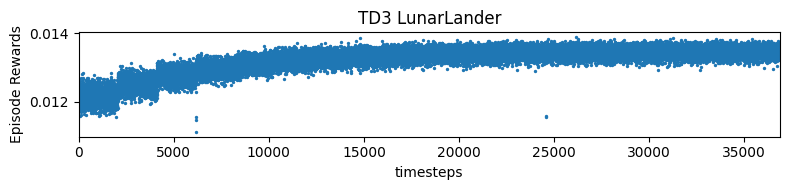

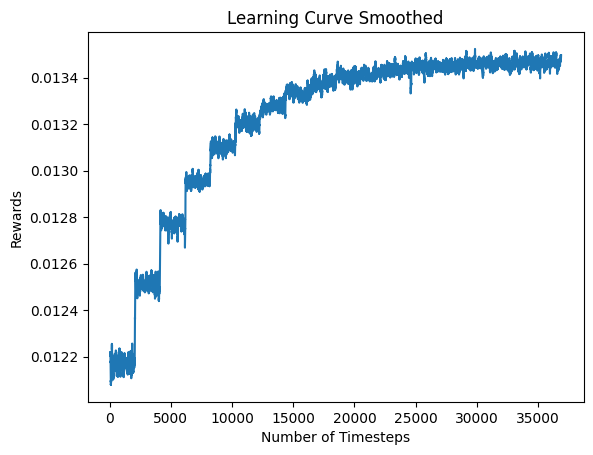

In [ ]:
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "TD3 LunarLander"
)

plot_results(log_dir)

**Testing and Getting Results for Analysis**

8.) Same graph enviroment, but outputs the reward when function is called

In [ ]:
# define class for custom enviroment
class GraphEnv2(gym.Env):
  metadata = {'render.modes': ['human']}

  # function to assign edge array with corresponding weights
  def assign_edges(self,nodes):
    edges = np.zeros(self.num_edges)
    counter = 0
    for i in range(len(nodes[:,0])):
      for j in range(i+1,len(nodes[:,0])):
        if(nodes[i,j] > 0):
          edges[counter] = nodes[i,j]
        else:
          edges[counter] = nodes[i,j]
        counter = counter + 1
    return edges

  # enviroment initialization
  def __init__(self,nodes):
    super(GraphEnv2, self).__init__()
    self.num_nodes = len(nodes[:,0])
    self.num_edges = int((self.num_nodes*(self.num_nodes-1))/2)
    self.nodes = nodes
    self.edges = self.assign_edges(nodes)

    # calculate bounds of domain for possible edge manipulations
    low = 0.1 - self.edges
    high = (2*self.num_edges - 0.1*2*(self.num_edges-1))*np.ones(self.num_edges) - self.edges

    highest_possible_edge_weight = 2*self.num_edges - 0.1*2*(self.num_edges-1)

    # set action and observation(state) spaces
    self.action_space = spaces.Box(low=low, high=high, shape=np.array([self.num_edges]), dtype=np.float64)
    self.observation_space = spaces.Box(low=0.1, high=highest_possible_edge_weight , shape=np.array([self.num_edges]), dtype=np.float64)

  # function to construct laplacian matrix
  def construct_lap(self):
    edge_sum = 0

    for i in range(self.num_edges):
      edge_sum = edge_sum + self.edges[i]

    norm_ratio = self.num_edges / edge_sum

    for i in range(self.num_edges):
      self.edges[i] = np.float64(self.edges[i] * norm_ratio)


    lap = np.zeros((self.num_nodes,self.num_nodes))
    counter = 0
    for i in range(len(self.nodes[:,0])):
      for j in range(i+1,len(self.nodes[:,0])):
        if(self.nodes[i,j] > 0):
          lap[i,j] = -self.edges[counter]
          lap[j,i] = -self.edges[counter]
          lap[i,i] = lap[i,i] + self.edges[counter]
          lap[j,j] = lap[j,j] + self.edges[counter]
          counter = counter + 1

    # saves Laplacian matrix to file
    file1 = open('Graphs_and_Env/Laplacian-Optimized.txt', 'w')
    for i in range(len(self.nodes[:,0])):
      for j in range(len(self.nodes[:,0])):
        file1.write(str(lap[i,j]))
        file1.write("\n")

    file1.close()
    return lap

  # function to get reward(which is objective function value)
  def get_reward(self):
    L = self.construct_lap()

    nVertices = len(L[:,0])
    eigenvalues1, eigenvectors1 = LA.eig(L)
    L = L + 0.1*np.identity(nVertices)
    eigenvalues, eigenvectors = LA.eig(L)
    ev = np.sort(eigenvalues)
    print("Sum of Eigenvalues from Policy Evaluation:",np.sum(eigenvalues1)) # outputs the sum of EV

    gamma = 0.001
    h = 0.1

    value = 0
    for i in range(len(ev)):
        lambda_i = ev[i]
        for j in range(len(ev)):
            lambda_j = ev[j]
            value += ((h*(h**2+lambda_j)+h*lambda_i) / (gamma*nVertices*lambda_j*(lambda_i**2+2*lambda_i*(h**2-lambda_j)+(h**2+lambda_j)**2)))

    value /= nVertices

    return abs(value)

  # function to return observation
  def _get_obs(self):
    return self.edges

  # function to return edge info
  def _get_info(self):
    return {"edges": self.edges}

  # function to perform step
  def step(self, action: np.ndarray,):
    # perform action
    action = np.float64(action)
    self.edges = np.float64(self.edges + action)

    # normalize weights
    edge_sum = 0
    for i in range(self.num_edges):
      edge_sum = edge_sum + self.edges[i]

    norm_ratio = self.num_edges / edge_sum

    for i in range(self.num_edges):
      self.edges[i] = np.float64(self.edges[i] * norm_ratio)

    # reassign values for node array
    counter = 0
    for i in range(len(self.nodes[:,0])):
      for j in range(i+1,len(self.nodes[:,0])):
        if(self.nodes[i,j] > 0):
          self.nodes[i,j] = self.edges[counter]
          self.nodes[j,i] = self.edges[counter]
          counter = counter + 1

    # get reward
    reward = self.get_reward()

    observation = self._get_obs()
    info = self._get_info()
    return observation, reward, True, True, info

  # function to reset state values
  def reset(self, seed=None):
    super(GraphEnv2, self).__init__()

    # reset node array values
    self.new_nodes = np.zeros((self.num_nodes,self.num_nodes))
    for i in range(self.num_nodes):
      for j in range(self.num_nodes):
        if(i != j):
          self.new_nodes[i,j] = 1

    #self.nodes = self.new_nodes

    # reset edge weight values
    #self.edges = np.ones(self.num_edges)

    observation = self._get_obs()
    info = self._get_info()

    return observation, info

  # helper function for displaying graph
  def numpy_to_graph(self, A,type_graph='dgl',node_features=None):
      G = nx.from_numpy_array(A)

      if node_features != None:
          for n in G.nodes():
              for k,v in node_features.items():
                  G.nodes[n][k] = v[n]

      if type_graph == 'nx':
          return G

      G = G.to_directed()

      if node_features != None:
          node_attrs = list(node_features.keys())
      else:
          node_attrs = []

      g = dgl.from_networkx(G, node_attrs=node_attrs, edge_attrs=['weight'])
      return g

  # function to display graph
  def render(self, mode='human', close=False):
    G = self.numpy_to_graph(self.nodes,type_graph='nx')

    #pos=nx.circular_layout(G)

    jet = cm = plt.get_cmap('Greys')
    cNorm  = colors.Normalize(vmin=0, vmax=np.max(self.edges))
    sm = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    colorList = []

    for i in range(self.num_edges):
      colorVal = sm.to_rgba(self.edges[i])
      colorList.append(colorVal)

    #nx.draw(G,pos,edge_color=colorList)
    nx.draw(G,edge_color=colorList)
    plt.colorbar(sm)
    plt.show()

9.) Plot Graphs and Eigenvalue Spectrum for Initial Graph, Preference Comparison Optimized Graph, and Gradient Descent Optimized Graph

Initial Graph
Sum of Eigenvalues read from file: 870.0
Initial Objective Value: 213.2312479911742


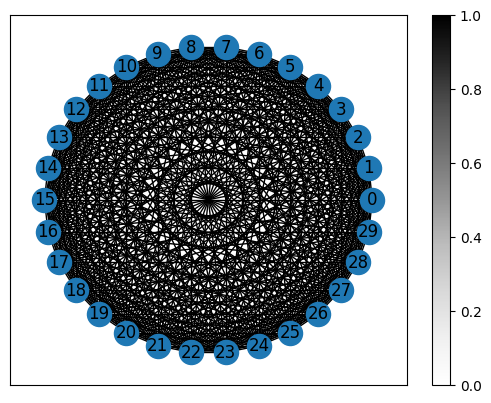

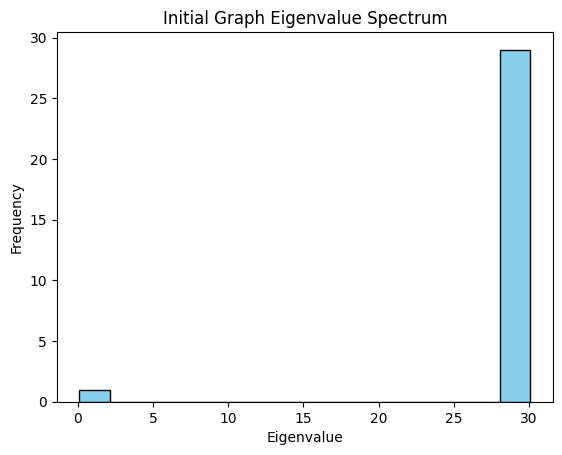

Preference Comparison Optimized Graph
Sum of Eigenvalues from Policy Evaluation: 870.000000000001
Sum of Eigenvalues read from file: 870.000000000001
Preference Comparison Objective Value: 73.53914634280568


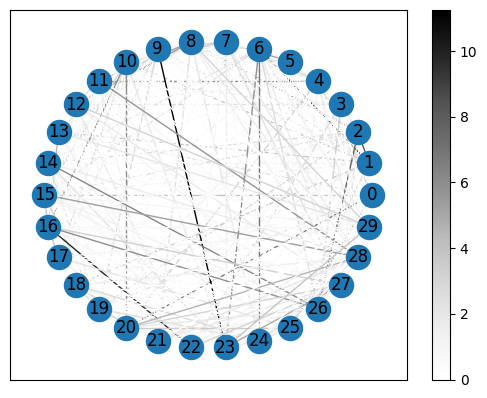

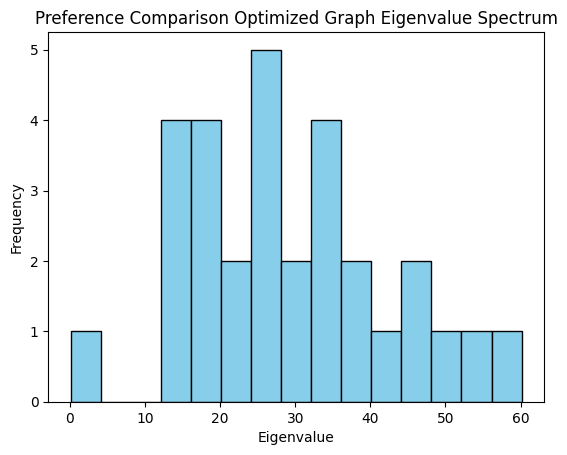

Gradient Descent Optimized Graph(For Comparison)
Sum of Eigenvalues read from file: 869.9999999999993
Gradient Descent Optimized Graph Objective Value: 71.04451721402607


In [ ]:
print("Initial Graph")
A,L,num_edges = get_adj_lap("Graphs_and_Env/Initial-Laplacian.txt")
graph = gym.make('gym_graph/GraphEnv',nodes=A)
obj_val, ev = Obj_Val(L)
print("Initial Objective Value:",obj_val)
graph.reset()
graph.render()

# Plotting a basic histogram
plt.hist(ev, bins=15, color='skyblue', edgecolor='black')
plt.xlabel('Eigenvalue')
plt.ylabel('Frequency')
plt.title('Initial Graph Eigenvalue Spectrum')
plt.show()

print("Preference Comparison Optimized Graph")
env = make_vec_env(GraphEnv2,n_envs=1, env_kwargs={'nodes':A})
evaluate_policy(model.policy, env, n_eval_episodes,render=True)
A,L,num_edges = get_adj_lap("Graphs_and_Env/Laplacian-Optimized.txt")
obj_val, ev = Obj_Val(L)

print("Preference Comparison Objective Value:",obj_val)
final_graph = gym.make('gym_graph/GraphEnv',nodes=A)
final_graph.reset()
final_graph.render()
plt.hist(ev, bins=15, color='skyblue', edgecolor='black')
plt.xlabel('Eigenvalue')
plt.ylabel('Frequency')
plt.title('Preference Comparison Optimized Graph Eigenvalue Spectrum')
plt.show()


print("Gradient Descent Optimized Graph(For Comparison)")
A,L,num_edges = get_adj_lap("Graphs_and_Env/LapResults30.txt")
graph = gym.make('gym_graph/GraphEnv',nodes=A)
obj_val, ev = Obj_Val(L)
print("Gradient Descent Optimized Graph Objective Value:",obj_val)

Zip File For Saving

In [ ]:
import os
from IPython.display import clear_output
!zip -r ./Graphs_and_Env.zip ./Graphs_and_Env/
clear_output(wait=False)
os.chdir('/content')

Gradient Descent Optimized Graph(For Comparison)
Sum of Eigenvalues read from file: 72.00000000000004
Gradient Descent Optimized Graph Objective Value: 946.1432529152822
Preference Comparison Objective Value: 946.1432529152822


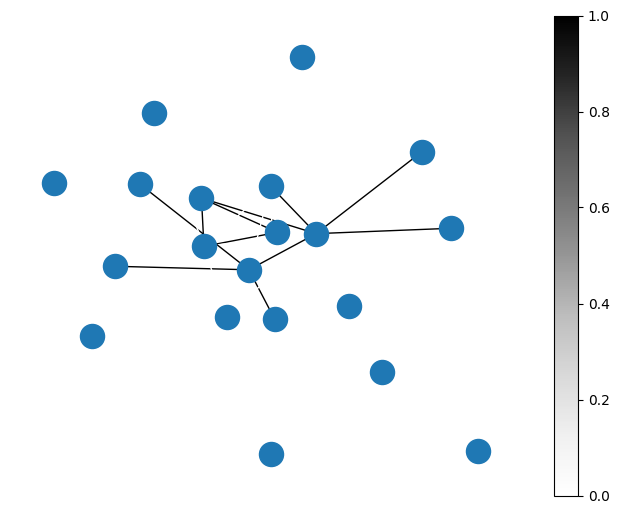

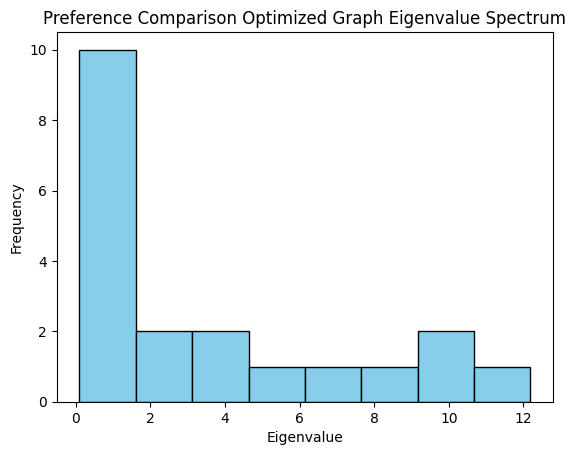

In [ ]:

print("Gradient Descent Optimized Graph(For Comparison)")
A,L,num_edges = get_adj_lap("L_init-4-30.txt")
graph = gym.make('gym_graph/GraphEnv',nodes=A)
obj_val, ev = Obj_Val(L)
print("Gradient Descent Optimized Graph Objective Value:",obj_val)

print("Preference Comparison Objective Value:",obj_val)
final_graph = gym.make('gym_graph/GraphEnv',nodes=A)
final_graph.reset()
final_graph.render()
plt.hist(ev, bins=8, color='skyblue', edgecolor='black')
plt.xlabel('Eigenvalue')
plt.ylabel('Frequency')
plt.title('Preference Comparison Optimized Graph Eigenvalue Spectrum')
plt.show()